# Step 1: Import Libraries

### For more details,visit the official documentation:

## [PyTorch](https://pytorch.org/docs/stable/index.html)


## [Torch.nn](https://pytorch.org/docs/stable/nn.html)



## [Torchvision](https://pytorch.org/vision/stable/index.html)

In [ ]:
import matplotlib.pyplot as plt # for visualizing
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import math
import torch.nn as nn
from collections import OrderedDict

print(torch.__version__)
print(torchvision.__version__)


2.8.0+cu126
0.23.0+cu126


# Step 2: Setting Up Device(GPU-Agnostic code)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
#check our GPU
!nvidia-smi

Sat Sep 27 10:24:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Step 3: Loading the MNIST Dataset & Mount the drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
origin_dir = '/content/drive/MyDrive/Colab_Notebooks/URP/VGG16_CIFAR100_pruning'
data_dir = origin_dir + '/data'

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # 데이터 증강: 랜덤 크롭
    transforms.RandomHorizontalFlip(),      # 좌우 반전
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
    #데이터 증강 기법을 자동으로 탐색 후 적용
    transforms.ToTensor(),                  # Tensor 변환
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
  transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # CIFAR-100 평균/표준편차
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408),
                         (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(
    root = data_dir, train=True, download=True, transform=transform_train
)

testset = torchvision.datasets.CIFAR100(
    root= data_dir, train=False, download=True, transform=transform_test
)


100%|██████████| 169M/169M [00:13<00:00, 12.2MB/s]


# Step 4: Creating Dataloaders for Training and Testing

In [ ]:
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)

trainloader,testloader

(<torch.utils.data.dataloader.DataLoader at 0x7aedfb761760>,
 <torch.utils.data.dataloader.DataLoader at 0x7aedfb7e9ca0>)

In [ ]:
import pandas as pd

def create_dataframe (dataloader,dataset_name=str):
    len_data=len(dataloader.dataset)
    num_classes=len(dataloader.dataset.classes)
    #class_name=dataloader.dataset.classes
    sample_image,label=next(iter(dataloader))
    image_shape=sample_image.shape
    batch=len(dataloader)
    label_shape=label.shape
    image_type=sample_image.dtype
    data={'Dataset Name':[dataset_name],
          'Number of images':[len_data],
          'Number of Batch':[batch],
          'Number of classes':[num_classes],
          #'Class names':[class_name],
          'Label shape':[label_shape],
          'Type of images':[image_type],
          'Image shape [N,C,H,W]':[[image_shape]]}
    df=pd.DataFrame(data)
    return df


In [ ]:
train_df=create_dataframe(trainloader,'Train')
test_df=create_dataframe(testloader,'Test')

pd.concat([train_df,test_df])

,Dataset Name,Number of images,Number of Batch,Number of classes,Label shape,Type of images,"Image shape [N,C,H,W]"
0,Train,50000,391,100,"(128,)",torch.float32,"[(128, 3, 32, 32)]"
0,Test,10000,79,100,"(128,)",torch.float32,"[(128, 3, 32, 32)]"


# Visualizing

In [ ]:
testloader.dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
norm_mean, norm_var = 0.0, 1.0

defaultcfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 512]
relucfg = [2, 6, 9, 13, 16, 19, 23, 26, 29, 33, 36, 39]
convcfg = [0, 3, 7, 10, 14, 17, 20, 24, 27, 30, 34, 37]


class VGG(nn.Module):
    def __init__(self, num_classes=100, init_weights=True, cfg=None):
        super(VGG, self).__init__()
        self.features = nn.Sequential()

        if cfg is None:
            cfg = defaultcfg

        self.relucfg = relucfg
        self.covcfg = convcfg
        self.features = self.make_layers(cfg[:-1], True)
        self.classifier = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(cfg[-2], cfg[-1])),
            ('norm1', nn.BatchNorm1d(cfg[-1])),
            ('relu1', nn.ReLU(inplace=True)),
            ('linear2', nn.Linear(cfg[-1], num_classes)),
        ]))

        if init_weights:            #weight 초기화
            self._initialize_weights()

    def make_layers(self, cfg, batch_norm=True):
        layers = nn.Sequential()
        in_channels = 3
        cnt = 0
        for i, v in enumerate(cfg):
            if v == 'M':
                layers.add_module('pool%d' % i, nn.MaxPool2d(kernel_size=2, stride=2))
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)

                layers.add_module('conv%d' % i, conv2d)
                layers.add_module('norm%d' % i, nn.BatchNorm2d(v))
                layers.add_module('relu%d' % i, nn.ReLU(inplace=True))
                in_channels = v
        return layers

    def forward(self, x):
        x = self.features(x)

        x = nn.AvgPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(0.5)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [ ]:
torch.cuda.manual_seed(42)
model=VGG().to(device)
model

VGG(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [ ]:
model = VGG()
checkpoint = origin_dir + '/original_model/checkpoint1/'
model.load_state_dict(torch.load(checkpoint + "model_epoch_60.pth", map_location=device))
model.to(device)

VGG(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.2 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy
from torchmetrics import  ConfusionMatrix
from torchmetrics.classification import MulticlassPrecision

In [ ]:
torch.cuda.manual_seed(42)

weight decay는 업데이트 할 때 가중치가 0에 가까워지게 하는 것 loss + λ * ||W||²
Bias는 값이 커도 모델이 큰 영향 x, 오히려 weight decay로 0으로 만들면 모델 성능 하락
BN는 자체적으로 overfitting 방지 + weight deacy까지 적용시 성능 하락

In [ ]:
def add_wd(model, weight_decay):
    decay, no_decay = [], []
    for n,p in model.named_parameters():
        if p.ndim == 1 or n.endswith(".bias"):      #BN의 weight는 1차원 + bias는 weigth decay에서 제외
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]

스케줄러 워밍엄
워밍엄: 초반 몇 epoch 동안 학습률을 아주 작게 하여 선형으로 키움 (급격한 업데이트로 인한 발산과 불안정 방지, batchnorm, 큰 LR, 강한 증강에서 유리)
코사인 디케이: 남은 구간에서 학습률을 부드럽게 0에 수렵시킴

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR


base_lr = 0.01
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
optimizer = optim.SGD(add_wd(model, weight_decay=5e-4),
                      lr=base_lr, momentum=0.9 # 관성 효과
                      , nesterov=True        # L2 정규화 (overfitting 방지)
                      )
accuracy = Accuracy(task="multiclass", num_classes=len(trainset.classes)).to(device)


In [ ]:

def train_step(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device):
    train_time_start = timer()
    train_loss,train_acc=0,0
    training_loss,training_acc=0,0
    model.train()
    for image, y in data_loader:
        image, y= image.to(device), y.to(device)#.long()
        y_pred = model(image)
        loss= loss_fn(y_pred, y)
        training_loss += loss.item()
        training_acc += accuracy_fn(y_pred.argmax(dim=1), y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = training_loss / len(data_loader)
    train_acc = 100 * training_acc / len(data_loader)


    train_time_end = timer()                   #Learning Rate :{scheduler.get_last_lr()[0]:.3f}

    print(f"\033[92mTrain_loss:{train_loss:.4f}%\n Train_acc:{train_acc:.4f}%\nDevice is on {device}\nTime passed for training:{train_time_end-train_time_start:.2f}s\033[0m")
    return train_loss,train_acc

def test_step(model:torch.nn.Module,dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,accuracy_fn,device:torch.device):
    model.eval()
    test_loss,test_acc=0,0
    testing_loss,testing_acc=0,0
    with torch.inference_mode():
        test_time_start = timer()
        for image,y in dataloader:
            image,y=image.to(device),y.to(device)
            test_pred=model(image)
            testing_loss+=loss_fn(test_pred,y).item()
            testing_acc+=accuracy_fn(test_pred.argmax(dim=1), y)

        test_loss = testing_loss / len(dataloader)
        test_acc= 100 * testing_acc / len(dataloader)

        test_time_end=timer()
        print(f"\033[94mTest loss is-->{test_loss:.4f}%\nTest acc is-->{test_acc:.4f}%\nDevice is on {str(next(model.parameters()).device)}\nTime passed for testing:{test_time_end-test_time_start:.2f}s\033[0m")

        return test_loss,test_acc


In [ ]:
job_dir = origin_dir + '/original_model/'

Epoch 57 Train_loss:0.3360% Train_acc:89.5053% Device is on cuda:0 Time passed for training:24.36s Test loss is-->1.3513% Test acc is-->67.9885% Device is on cuda:0 Time passed for testing:2.37s

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

epochs=60
warmup_epochs = 5

scheduler = SequentialLR(
      optimizer,
      schedulers=[
          LinearLR(optimizer, start_factor=0.01, total_iters=warmup_epochs),   # ❷
          CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=1e-5)  # ❸
      ],
      milestones=[warmup_epochs]
  )

train_accuracies=[]
train_losses=[]
test_accuracies=[]
test_losses=[]

time_start = timer()
for epoch in tqdm(range(1, epochs+1)):
    print(f"Epoch {epoch+60}")
    train_loss,train_acc=train_step(model,trainloader,loss_fn,optimizer,accuracy,device=str(next(model.parameters()).device))
    test_loss,test_acc=test_step(model,testloader,loss_fn,accuracy,device=str(next(model.parameters()).device))

    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    if epoch % 10 == 0:
      torch.save(model.state_dict(), job_dir + f"model_epoch_{epoch+60}.pth")
      print(f"Saved checkpoint as {job_dir}")
    print(f"------------------------")


time_end=timer()
print(f'Total time passed :\033[91m{time_end-time_start:.4f}s\033[0m')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 61
Train_loss:2.1464%
 Train_acc:57.9871%
Device is on cuda:0
Time passed for training:38.96s
Test loss is-->1.8950%
Test acc is-->63.7757%
Device is on cuda:0
Time passed for testing:3.51s
------------------------
Epoch 62
Train_loss:1.9341%
 Train_acc:63.8979%
Device is on cuda:0
Time passed for training:39.16s
Test loss is-->1.7191%
Test acc is-->68.7203%
Device is on cuda:0
Time passed for testing:3.26s
------------------------
Epoch 63
Train_loss:1.8208%
 Train_acc:67.3685%
Device is on cuda:0
Time passed for training:39.64s
Test loss is-->1.6812%
Test acc is-->70.2433%
Device is on cuda:0
Time passed for testing:3.18s
------------------------
Epoch 64
Train_loss:1.7784%
 Train_acc:68.2717%
Device is on cuda:0
Time passed for training:38.44s
Test loss is-->1.6629%
Test acc is-->70.8663%
Device is on cuda:0
Time passed for testing:3.42s
------------------------
Epoch 65
Train_loss:1.7354%
 Train_acc:69.7259%
Device is on cuda:0
Time passed for training:38.09s
Test loss is-->1

In [ ]:
model

VGG(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu4): ReLU(inplace=True)
    (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [ ]:
defaultcfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 512]
relucfg = [2, 6, 9, 13, 16, 19, 23, 26, 29, 33, 36, 39]
convcfg = [0, 3, 7, 10, 14, 17, 20, 24, 27, 30, 34, 37, 40]
model.features[convcfg[2]]


for idx in conv_idxs:
    conv: nn.Conv2d = model.features[idx]
    print(conv)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
torch.save({'model_state_dict':model.state_dict(),
            'input_features':model.classifier.in_features,
            'output_features':model.output_shape}, job_dir +'/Pre_trained_Model.pt')

AttributeError: 'Sequential' object has no attribute 'in_features'

In [ ]:
torch.manual_seed(42)
loaded_model=VGG()


#checkpoint
chekpoint=torch.load(job_dir +'/Pre_trained_Model.pt')
#load in the save state_dict()

loaded_model.load_state_dict(chekpoint['model_state_dict'])
loaded_model.eval()


In [ ]:
import plotly.graph_objects as go

epochs=list(range(1,len(train_accuracies)+1))


train=go.Scatter(x=epochs,
                 y=train_accuracies,
                 mode='lines+markers',
                 name='Train Acc',line=dict(color='royalblue'))



test=go.Scatter(x=epochs,
                 y=test_accuracies,
                 mode='lines+markers',
                 name='Test Acc',line=dict(color='orange'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Accuracy per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Accuracy',
                    template='plotly_white')

figure.show()

In [ ]:
epochs=list(range(1,len(train_losses)+1))


train=go.Scatter(x=epochs,
                 y=train_losses,
                 mode='lines+markers',
                 name='Train Loss',line=dict(color='red'))



test=go.Scatter(x=epochs,
                 y=test_losses,
                 mode='lines+markers',
                 name='Test Loss',line=dict(color='black'))

figure=go.Figure(data=[train,test])
figure.update_layout(title='Train and Test Loss per Epoch',
                    xaxis_title='Epochs',
                    yaxis_title='Loss',
                    template='plotly_white')

figure.show()

# Evaluate:

In [ ]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
test_loss,test_acc=test_step(model,testloader,loss_fn,accuracy,device=str(next(model.parameters()).device))

Test loss is-->1.6131%
Test acc is-->75.0791%
Device is on cuda:0
Time passed for testing:3.49s


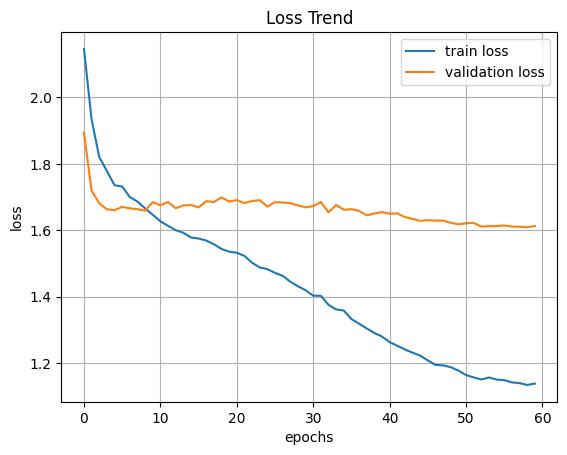

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='validation loss')

plt.legend()

plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

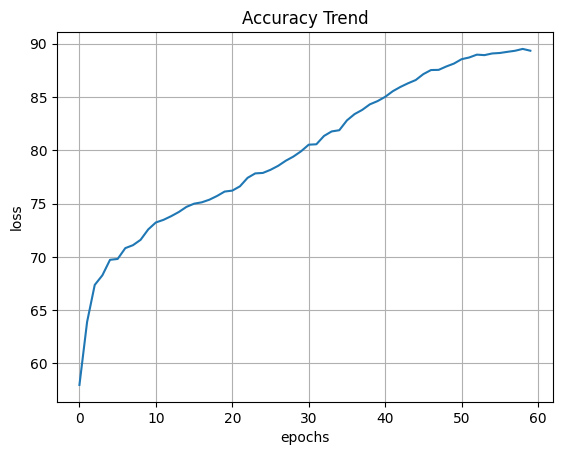

In [ ]:
import matplotlib.pyplot as plt

plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_accuracies, label='train loss')
plt.plot(test_accuracies, label='validation loss')

plt.legend()

plt.show()

# ConfusionMatrix:

# Save model:

In [ ]:
torch.save({'model_state_dict':model.state_dict(),
            'input_features':model.classifier1.in_features,
            'output_features':model.output_shape},'noskip_origin_mnist_model.pt')


In [ ]:
torch.save(model, "entire_model.pt")